In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from selenobot.files import XMLFile 
from selenobot.utils import digitize, groupby, sample
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from selenobot.tools import Clusterer

sys.path.append('../scripts/')
from build import clean, process

%load_ext autoreload
%autoreload 2


DATA_DIR = '/home/prichter/Documents/selenobot/data/'

In [98]:
def plot_length_distribution(metadata_dfs:List[pd.DataFrame], ax:plt.Axes=None, bins:int=25, density:bool=False):

    n_dropped, lengths = 0, []
    for df in metadata_dfs:
        nans = df.seq.isnull()
        n_dropped += nans.sum()
        lengths.append(df[~nans].seq.apply(len).values)
    print(f'plot_length_distribution: Dropped {n_dropped} empty sequences.')

    ax.hist(lengths, density=density, bins=bins, edgecolor='white')
    ax.set_ylabel('density' if density else 'count')
    ax.set_xlabel('length')


# Dataset construction

In [4]:
uniprot_sprot_df = clean(pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sprot.csv'), index_col=0), allow_c_terminal_fragments=True, remove_selenoproteins=False)
uniprot_sec_df = clean(pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'), index_col=0), allow_c_terminal_fragments=False, remove_selenoproteins=False)

clusterer = Clusterer(name='uniprot_sec', cwd='./out', tool='mmseqs')
uniprot_sec_df = clusterer.dereplicate(uniprot_sec_df, overwrite=False)
uniprot_sec_df['seq_truncated'] = uniprot_sec_df.seq.apply(lambda s : s[:s.index('U')])
uniprot_sec_df['truncation_ratio'] = (uniprot_sec_df.seq.apply(len) - uniprot_sec_df.seq_truncated.apply(len)) / uniprot_sec_df.seq.apply(len)

clean: Removed 235396 non-bacterial proteins from the DataFrame. 336468 sequences remaining.
clean: Removed 140 proteins which exceed 2000 amino acids in length from the DataFrame. 336328 sequences remaining.
clean: Removed 699 fragment proteins from the DataFrame. 335629 sequences remaining.
clean: Removed 3216 non-bacterial proteins from the DataFrame. 16412 sequences remaining.
clean: Removed 0 proteins which exceed 2000 amino acids in length from the DataFrame. 16412 sequences remaining.
clean: Removed 958 fragment proteins from the DataFrame. 15454 sequences remaining.
MMseqs.run: Using pre-saved clustering results at ./out/dereplicate_uniprot_sec
Clusterer.dereplicate: Dereplication of clusters with 0.95 similarity eliminated 4412 sequences from uniprot_sec. 11042 sequences remaining.


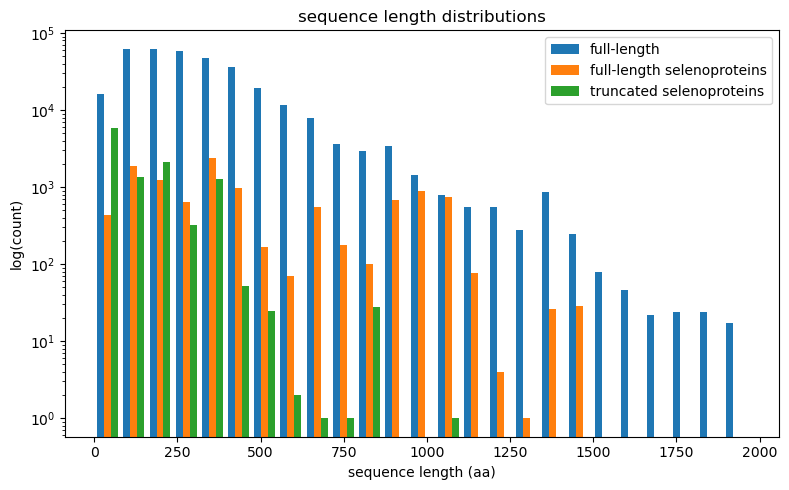

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist((uniprot_sprot_df.seq.apply(len), uniprot_sec_df.seq.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
ax.set_yscale('log')
ax.legend(['full-length', 'full-length selenoproteins', 'truncated selenoproteins'])
ax.set_title('sequence length distributions')
ax.set_ylabel('log(count)')
ax.set_xlabel('sequence length (aa)')

plt.tight_layout()
plt.show()

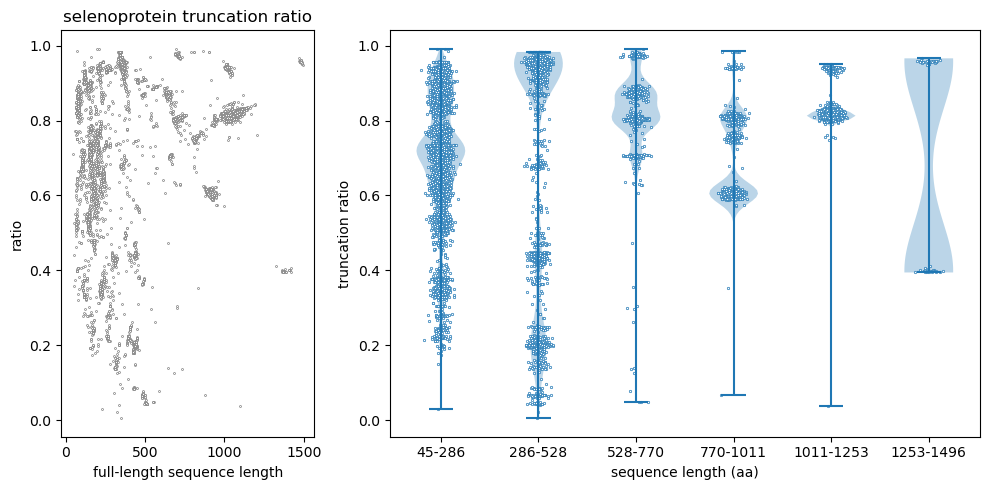

In [51]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), width_ratios=[0.3, 0.7])

axes[0].set_xlabel('full-length sequence length')
axes[0].set_ylabel('ratio')
axes[0].set_title('selenoprotein truncation ratio')
x = uniprot_sec_df.seq.apply(len)
y = (uniprot_sec_df.seq.apply(len) - uniprot_sec_df.seq_truncated.apply(len)) / uniprot_sec_df.seq.apply(len) 
axes[0].scatter(x, y, s=2, facecolor='white', linewidth=0.5, edgecolor='gray')

# TODO: https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517 
# TODO: https://stackoverflow.com/questions/3510475/generate-random-numbers-according-to-distributions 

n_bins = 6
hist, bin_edges = np.histogram(uniprot_sec_df.seq.apply(len).values, bins=n_bins)
bin_labels, bin_names = digitize(uniprot_sec_df.seq.apply(len).values, bin_edges)
binned_ratios = groupby(uniprot_sec_df.truncation_ratio.values, bin_labels)

data = [np.sort(binned_ratios[bin_label]) for bin_label in range(1, n_bins + 1)]
axes[1].violinplot(data, orientation='vertical')
for bin_label, ratios in binned_ratios.items():
    x_values = np.array([bin_label] * len(ratios))
    offsets = np.random.normal(size=len(ratios), scale=0.05)
    axes[1].scatter(x_values + offsets, ratios, color='tab:blue', s=3, facecolor='white', linewidth=0.5)
axes[1].set_xticks(np.arange(n_bins) + 1, bin_names)
axes[1].set_xlabel('sequence length (aa)')
axes[1].set_ylabel('truncation ratio')

plt.tight_layout()
plt.show()

# NOTE: There appears to be very little correlation between length of the original sequence and the amount of the
# sequence which is truncated. However, it is pretty clear that the data are heteroscedastic. To properly reproduce the 
# distribution, I am going to try binning by length first. 

In [7]:
def truncate(df:pd.DataFrame, sec_seqs:np.ndarray, n_bins:int=25, bandwidth:float=0.01) -> pd.DataFrame:
    '''Sub-sample the set of all full-length proteins such that the length distribution matches that of the full-length
    selenoproteins. Then, truncate the sampled sequences so that the truncated length distributions also match.

    :param df: The DataFrame containing the complete set of SwissProt proteins. 
    :param n_bins: The number of bins to use for producing a length distribution of full-length selenoproteins. 
        This is used when initially down-sampling SwissProt. 
    :param bandwidth: The bandwidth to use for the kernel density estimation, which is used for creating 
        distributions for selecting truncation ratios. 
    :return: A pandas DataFrame containing the sub-sampled and randomly truncated SwissProt proteins. 
    '''
    sec_seqs_truncated = np.array([seq.split('U')[0] for seq in sec_seqs])
    sec_lengths = np.array([len(seq) for seq in sec_seqs])
    sec_lengths_truncated = np.array([len(seq) for seq in sec_seqs_truncated]) 

    sec_truncation_ratios = (sec_lengths - sec_lengths_truncated) / sec_lengths

    hist, bin_edges = np.histogram(sec_lengths, bins=n_bins)
    bin_labels, bin_names = digitize(sec_lengths, bin_edges)

    _, idxs = sample(df.seq.apply(len).values, hist, bin_edges)
    df = df.iloc[idxs].copy()
    df['bin_label'], _ = digitize(df.seq.apply(len).values, bin_edges)

    kdes = dict()
    for bin_label, bin_values in groupby(sec_truncation_ratios, bin_labels).items():
        kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=bandwidth) 
        kde.fit(bin_values.reshape(-1, 1))
        kdes[bin_label] = kde

    df_truncated = []
    for bin_label, bin_df in df.groupby('bin_label'):
        bin_df['truncation_size'] = kdes[bin_label].sample(n_samples=len(bin_df)).ravel() * bin_df.seq.apply(len).values
        bin_df['seq'] = bin_df.apply(lambda row : row.seq[:-int(row.truncation_size)], axis=1)
        df_truncated.append(bin_df)

    return pd.concat(df_truncated)



## Binary classification

For binary classification, the goal is to train a model to distinguish between full-length non-selenoproteins and truncated selenoproteins. For this task, we have two datasets:
1. All of the non-fragmented proteins in SwissProt, with the selenoproteins removed. 
2. All selenoproteins registered in UniProt, truncated at the first selenocysteine residue. 

**Problem:** The binary model, when run on GTDB, seems to be flagging too many sequences as selenoproteins. There are several possibilities for what might be happening: (1) There are actually tons of truncated selenoproteins, which seems unlikely, (2) there are full-length which kind of resemble truncated selenoproteins that are being flagged, (3) there are truncated proteins that are not selenoproteins. 

In [91]:
# Want to take a look at the datasets a bit. Especially because of the weird behavior I am seeing with performance on the test set
# being substantially higher for binary classifiers. 

train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
train_metadata_df = train_metadata_df[train_metadata_df.label.isin([0, 1])]

test_metadata_df = pd.read_csv('../data/test.csv', index_col=0)
test_metadata_df = test_metadata_df[test_metadata_df.label.isin([0, 1])]

val_metadata_df = pd.read_csv('../data/val.csv', index_col=0)
val_metadata_df = val_metadata_df[val_metadata_df.label.isin([0, 1])]  

plot_length_distribution: Dropped 0 empty sequences.


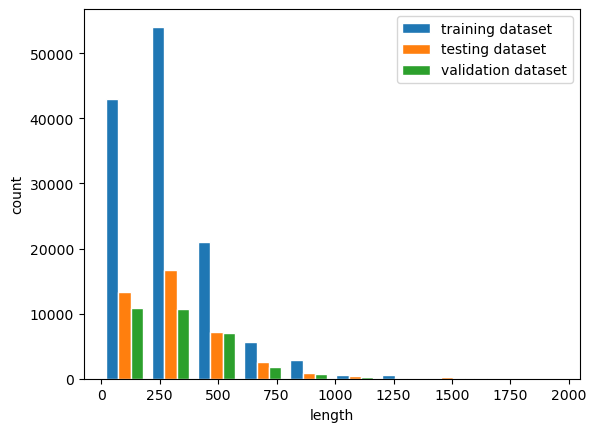

In [99]:
fig, ax = plt.subplots()
plot_length_distribution([train_metadata_df, test_metadata_df, val_metadata_df], ax=ax, bins=10)
ax.legend(['training dataset', 'testing dataset', 'validation dataset'])
plt.show()


## Ternary classification

For ternary classification, the goal is to train a model to distinguish between full-length non-selenoproteins, truncated selenoproteins, and truncated non-selenoproteins. The reasoning behind this is to determine if the "false positives" I think the model is classifying as truncated selenoproteins might simply be truncated regular proteins. However, I really have no sense as to whether or not these hits are being identified because they specifically look like truncated selenoproteins (i.e., similar in length, composition, or something else), or just because they are truncated. 

1. Randomly sub-sample with replacement (for convenience, I used the same size sample as the selenoprotein subset) from the non-dereplicated SwissProt database. Ensure that the length distribution of the subsample matches the full-length selenoproteins, and that none of the sampled sequences are full-length selenoproteins. 
2. Truncate the sub-sampled sequences according to their length. The resulting length distribution of the truncated selenoproteins matches the distribution of the truncated selenoproteins. 
3. De-replicate the truncated non-selenoproteins. 



In [9]:
# longest_sec = max(uniprot_sec_df.seq.apply(len))
# print('Longest full-length selenoproteins:', longest_sec)

original_seqs = uniprot_sprot_df[['seq']].copy()

uniprot_sprot_sample_df = truncate(uniprot_sprot_df.copy(), sec_seqs=uniprot_sec_df.seq.values, n_bins=10)
uniprot_sprot_sample_df = uniprot_sprot_sample_df.rename(columns={'seq':'seq_truncated'})
uniprot_sprot_sample_df = uniprot_sprot_sample_df.merge(original_seqs, left_index=True, right_index=True, how='inner')

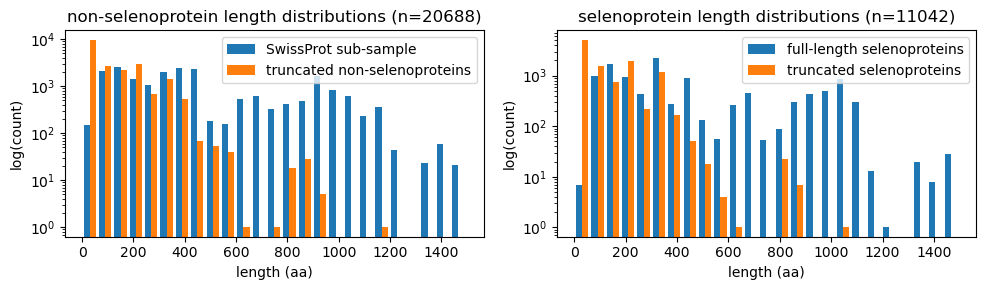

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len)), bins=25)
# axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[0].set_yscale('log')
axes[0].set_ylabel('log(count)')
axes[0].set_xlabel('length (aa)')
axes[0].legend(['SwissProt sub-sample', 'truncated non-selenoproteins'])
axes[0].set_title(f'non-selenoprotein length distributions (n={len(uniprot_sprot_sample_df)})')

axes[1].hist((uniprot_sec_df.seq.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
# axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[1].set_yscale('log')
axes[1].set_ylabel('log(count)')
axes[1].set_xlabel('length (aa)')
axes[1].legend(['full-length selenoproteins', 'truncated selenoproteins'])
axes[1].set_title(f'selenoprotein length distributions (n={len(uniprot_sec_df)})')

plt.tight_layout()
plt.show()

In [11]:
# # API URL for retrieving bacterial proteins which are non-TrEMBL reviewed, and have evidence at the transcript level. 
# # See this link for more info on protein existence: https://www.uniprot.org/help/protein_existence
# # https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=xml&query=%28%28taxonomy_id%3A2%29%29+AND+%28reviewed%3Afalse%29+AND+%28existence%3A2%29

# xml_file = NcbiXmlFile(os.path.join(DATA_DIR, 'uniprot_trembl.xml'))
# xml_file.to_df().to_csv(os.path.join(DATA_DIR, 'uniprot_trembl.csv'))

# Investigating bias

In [61]:
train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
test_metadata_df = pd.read_csv('../data/test.csv', index_col=0)
val_metadata_df = pd.read_csv('../data/val.csv', index_col=0)

metadata_df = pd.concat([train_metadata_df, test_metadata_df, val_metadata_df])

I am running into a problem where it seems that performance on the validation set is very inflated, particularly for the `aa_3mer` feature type. I want to double-check that the length distributions aren't skewed across datasets. 

plot_length_distribution: Dropped 5 empty sequences.


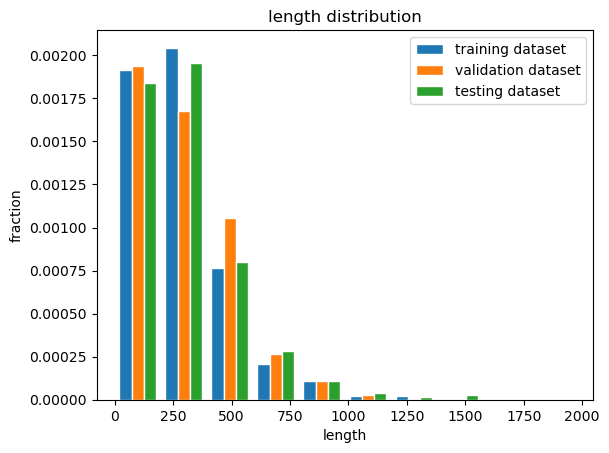

In [62]:
fig, ax = plt.subplots()
plot_length_distribution([train_metadata_df, val_metadata_df, test_metadata_df], ax=ax, bins=10)
ax.legend(['training dataset', 'validation dataset', 'testing dataset'])
plt.show()

In [63]:
levels = ['domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

N = len(metadata_df)
print('Total number of sequences:', N)

for level in levels:
    n = np.sum(~metadata_df[level].isnull())
    print(f'Number of sequences assigned a {level}:', n, f'({int((n / N) * 100)}%)')

Total number of sequences: 221239
Number of sequences assigned a domain: 221239 (100%)
Number of sequences assigned a kingdom: 221097 (99%)
Number of sequences assigned a phylum: 218287 (98%)
Number of sequences assigned a class: 216329 (97%)
Number of sequences assigned a order: 215381 (97%)
Number of sequences assigned a family: 209468 (94%)
Number of sequences assigned a genus: 31835 (14%)
Number of sequences assigned a species: 221239 (100%)


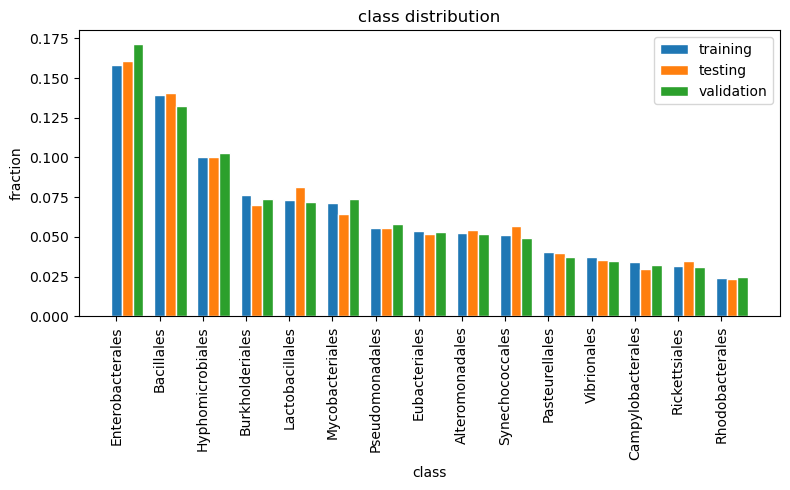

In [64]:
def plot_taxonomy_distribution(metadata_dfs:List[pd.DataFrame], level:str='class', title:str=None, taxa:List[str]=None, ax:plt.Axes=None, set_xlabel:bool=True):

    bar_width = 1 / (len(metadata_dfs) + 1)

    for i, metadata_df in enumerate(metadata_dfs):
        data = metadata_df.groupby(level).apply(len) 
        n = len(taxa) # Number of taxa to display. 
        n_total = len(data)
        heights = np.array([data.loc[t].item() if (t in data.index) else 0 for t in taxa])
        ax.bar(np.arange(n) + (i * bar_width), heights / heights.sum() , bar_width, edgecolor='white')

    ax.set_xticks(np.arange(n), labels=taxa, rotation=90)
    title = f'{level} distribution' if title is None else title
    
    ax.set_title(title)
    ax.set_ylabel('fraction')
    if set_xlabel:
        ax.set_xlabel(level)

    if len(metadata_dfs) == 1:
        inset_ax = ax.inset_axes([0.6, 0.3, 0.3, 0.7])
        n_shown = data[data.index.isin(taxa)].sum()
        n_remain = data[~data.index.isin(taxa)].sum()
        n_total = data.sum()
        inset_ax.pie([n_shown, n_remain], labels=[f'{int(100 * n_shown / n_total)} %', f'{int(100 * n_remain / n_total)} %'])

    plt.tight_layout()

fig, ax = plt.subplots(figsize=(8, 5))

top_taxa = metadata_df.groupby('class').apply(len).sort_values(ascending=False).index.values[:15]
plot_taxonomy_distribution([train_metadata_df, test_metadata_df, val_metadata_df], ax=ax, taxa=top_taxa)
ax.legend(['training', 'testing', 'validation'])


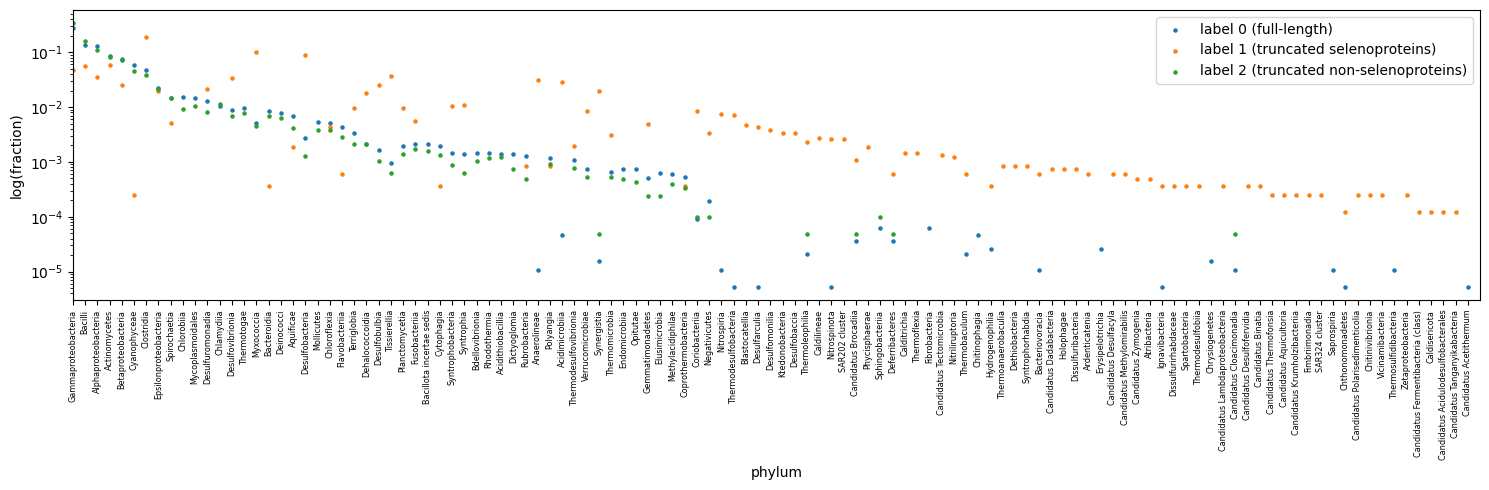

In [90]:
fig, ax = plt.subplots(figsize=(15, 5))

level = 'phylum'
top_taxa = metadata_df.groupby(level).apply(len).sort_values(ascending=False).index.values
n = len(top_taxa)

for label in [0, 1, 2]:
    y_values = metadata_df[metadata_df.label == label].groupby(level).apply(len).sort_values(ascending=False)
    y_values = y_values / y_values.sum() # Normalize according to dataset size. 
    y_values = y_values.reindex(top_taxa).fillna(0) # Standardize the order. 
    ax.scatter(np.arange(n), y_values.values, s=5)

ax.legend(['label 0 (full-length)', 'label 1 (truncated selenoproteins)', 'label 2 (truncated non-selenoproteins)'])
ax.set_yscale('log')
ax.set_xticks(np.arange(n), labels=top_taxa, rotation=90, fontsize='xx-small')
ax.set_xlim(0, n)
ax.set_ylabel('log(fraction)')
ax.set_xlabel(level)

plt.tight_layout()
plt.show()
